In [1]:
!pip3 install onemapsg

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/input-data/Train Station Codes and Chinese Names.csv
/kaggle/input/input-data/transport_node_bus_202208.csv


In [3]:
import json
import urllib
# from urlparse import urlparse
from urllib.parse import urlparse
import httplib2 as http #External library
import pandas as pd
from tqdm import tqdm
from onemapsg import OneMapClient
import time
import networkx as nx
import geopy.distance

In [4]:
#Authentication parameters
headers = { 'AccountKey' : 'esuwl3rGSEqFBc+rSpuWEg==',
            'accept' : 'application/json'} #this is by default

uri = 'http://datamall2.mytransport.sg' #Resource URL

bus_route_path = '/ltaodataservice/BusRoutes?$skip={}'
bus_route_out_file = "bus_routes{}.json"

bus_stops_path = '/ltaodataservice/BusStops?$skip={}'
bus_stop_out_file = "bus_stops{}.json"

In [5]:
def extract_data_datamall(headers,uri,path,save_path):
    data_list = []
    lim = 0
    control_var = True
    while(control_var):
#     for lim in range(0, 25501, 500):
        #API parameters
        url_path = path.format(lim)
        #Build query string & specify type of API call
        target = urlparse(uri + url_path)
        method = 'GET'
        body = ''
        #Get handle to http
        h = http.Http()
        #Obtain results
        response, content = h.request(target.geturl(),method,body,headers)
        #Parse JSON to print
        jsonObj = json.loads(content)
        if(len(jsonObj['value'])==0):
            control_var = False
        data_list.extend(jsonObj['value'])
        lim = lim + 500

    return data_list
  

## Bus stop info

In [6]:
bus_routes_all = extract_data_datamall(headers,uri,bus_route_path,bus_route_out_file)
print("exracted all bus routes")
bus_stop_info = extract_data_datamall(headers,uri,bus_stops_path,bus_stop_out_file)
print("extrcated all bus stops")

exracted all bus routes
extrcated all bus stops


In [7]:
print(len(bus_routes_all))
print(len(bus_stop_info))

25052
5075


In [8]:
bus_stop_info_processed = {}

for deets in bus_stop_info:
    bus_stop_info_processed[deets['BusStopCode']] = deets
    bus_stop_info_processed[deets['BusStopCode']].pop('BusStopCode')

In [9]:
bus_stop_volume_aug = pd.read_csv('/kaggle/input/input-data/transport_node_bus_202208.csv')
bus_stop_volume_aug['PT_CODE'] = bus_stop_volume_aug['PT_CODE'].astype(str)
bus_stop_volume_aug['PT_CODE'] = bus_stop_volume_aug['PT_CODE'].apply(lambda x: '0'+x if len(x) < 5 else x)
bus_stop_volume_aug.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2022-08,WEEKDAY,6,BUS,67551,2878,100
1,2022-08,WEEKENDS/HOLIDAY,6,BUS,67551,209,14
2,2022-08,WEEKENDS/HOLIDAY,7,BUS,66541,141,119
3,2022-08,WEEKDAY,7,BUS,66541,608,287
4,2022-08,WEEKENDS/HOLIDAY,17,BUS,54209,535,164


In [10]:
bus_stop_volume_aug['TOTAL_TAP_IN_VOLUME'] = bus_stop_volume_aug['TOTAL_TAP_IN_VOLUME'].astype(int)
bus_stop_volume_aug['TOTAL_TAP_OUT_VOLUME'] = bus_stop_volume_aug['TOTAL_TAP_OUT_VOLUME'].astype(int)
bus_stop_volume_aug.dtypes

YEAR_MONTH              object
DAY_TYPE                object
TIME_PER_HOUR            int64
PT_TYPE                 object
PT_CODE                 object
TOTAL_TAP_IN_VOLUME      int64
TOTAL_TAP_OUT_VOLUME     int64
dtype: object

In [11]:
bus_stop_vol_aug = bus_stop_info_processed.copy()

for i in tqdm(range(len(bus_stop_volume_aug))):
    value = bus_stop_vol_aug.get(bus_stop_volume_aug.iloc[i]['PT_CODE'],False)

    if(value == False):
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']] = {'weekdays':{'tap_in':[0]*24,'tap_out':[0]*24},'weekends':{'tap_in':[0]*24,'tap_out':[0]*24}}
    dict_keys = bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']].keys()
    if('weekdays' not in dict_keys or 'weekends' not in dict_keys):
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']].update({'weekdays':{'tap_in':[0]*24,'tap_out':[0]*24},'weekends':{'tap_in':[0]*24,'tap_out':[0]*24}})

    if(bus_stop_volume_aug.iloc[i]['DAY_TYPE'] == 'WEEKDAY'):
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekdays']['tap_in'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_IN_VOLUME'])
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekdays']['tap_out'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_OUT_VOLUME'])
    else:
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekends']['tap_in'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_IN_VOLUME'])
        bus_stop_vol_aug[bus_stop_volume_aug.iloc[i]['PT_CODE']]['weekends']['tap_out'][bus_stop_volume_aug.iloc[i]['TIME_PER_HOUR']] = int(bus_stop_volume_aug.iloc[i]['TOTAL_TAP_OUT_VOLUME'])

100%|██████████| 195803/195803 [03:56<00:00, 826.71it/s]


In [12]:
service_no_dict = {}

for deets in bus_routes_all:
    value = service_no_dict.get(deets['ServiceNo'],False)

    if(value == False):
        service_no_dict[deets['ServiceNo']] = {'busstop':[],'busstop_info':{}}

    service_no_dict[deets['ServiceNo']]['busstop'].append(deets['BusStopCode'])

    busstop_info = bus_stop_info_processed.get(deets['BusStopCode'],{})
    service_no_dict[deets['ServiceNo']]['busstop_info'][deets['BusStopCode']] = busstop_info
    service_no_dict[deets['ServiceNo']]['busstop_info'][deets['BusStopCode']].update(bus_stop_vol_aug[deets['BusStopCode']])

In [13]:
bus_stop_full_info = {}
for keys in service_no_dict.keys():
    bus_stop_full_info.update(service_no_dict[keys]['busstop_info'])

## Train stations info

In [14]:
train_station = pd.read_csv('/kaggle/input/input-data/Train Station Codes and Chinese Names.csv')
train_station.head()

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North-South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North-South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线
4,NS5,Yew Tee,油池,North-South Line,南北线


In [15]:
train_station_names = {}

for i in range(len(train_station)):
    try:
        train_station_names[train_station.iloc[i]['mrt_station_english']] = train_station_names[train_station.iloc[i]['mrt_station_english']] + '-' + train_station.iloc[i]['stn_code']
    except:
        train_station_names[train_station.iloc[i]['mrt_station_english']] = train_station.iloc[i]['stn_code']

In [16]:
new_stn_code = []
for i in range(len(train_station)):
    new_stn_code.append(train_station_names[train_station.iloc[i]['mrt_station_english']])

train_station['new_stn_code'] = new_stn_code

In [17]:
train_station_dict = {}

for i in range(len(train_station)):
    value = train_station_dict.get(train_station.iloc[i]['mrt_line_english'],False)
    if(value == False):
        train_station_dict[train_station.iloc[i]['mrt_line_english']] = {'stn_code':[],'stn_info':{}}
        
    train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_code'].append(train_station.iloc[i]['new_stn_code'])
    # train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info']['stn_name'] = train_station.iloc[i]['mrt_station_english']
    
    Client = OneMapClient("vaidyanathanabhishek@gmail.com", "ShakeShake033@")
    data_dict = Client.search(train_station.iloc[i]['stn_code'])['results'][0]

    # time.sleep(5)
  
    train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info'][train_station.iloc[i]['new_stn_code']] = {'stn_name':train_station.iloc[i]['mrt_station_english']}
    train_station_dict[train_station.iloc[i]['mrt_line_english']]['stn_info'][train_station.iloc[i]['new_stn_code']].update(data_dict)

In [18]:
train_station_full_info = {}

for keys in train_station_dict:
    train_station_full_info.update(train_station_dict[keys]['stn_info'])

## Save to json files

In [19]:
def write_to_json(dict_obj,file_name):
    with open(file_name, "w") as outfile:
        json.dump(dict_obj, outfile)
    print('written file to '+file_name)

write_to_json(service_no_dict,'service_no_dict.json')
write_to_json(bus_stop_full_info,'bus_stop_full_info.json')
write_to_json(train_station_dict,'train_station_dict.json')
write_to_json(train_station_full_info,'train_station_full_info.json')
write_to_json(bus_stop_info_processed,'bus_stop_info_processed.json')

written file to service_no_dict.json
written file to bus_stop_full_info.json
written file to train_station_dict.json
written file to train_station_full_info.json
written file to bus_stop_info_processed.json


## NetworkX - Graph

In [20]:
coords_1 = (bus_stop_full_info['28201']['Latitude'], bus_stop_full_info['28201']['Longitude'])
coords_2 = (train_station_full_info['NS1-EW24']['LATITUDE'], train_station_full_info['NS1-EW24']['LONGITUDE'])

print (geopy.distance.geodesic(coords_1, coords_2))

0.1305111865106769 km


In [21]:
bus_stop_nodes = list(bus_stop_vol_aug.keys())

In [22]:
transport_graph = nx.DiGraph()
for key in service_no_dict.keys():
    i = 0
    while i < (len(service_no_dict[key]['busstop'])-1):
        first_node = service_no_dict[key]['busstop'][i]
        second_node = service_no_dict[key]['busstop'][i+1]
        lat1 = service_no_dict[key]['busstop_info'][service_no_dict[key]['busstop'][i]]['Latitude']
        long1 = service_no_dict[key]['busstop_info'][service_no_dict[key]['busstop'][i]]['Longitude']
        lat2 = service_no_dict[key]['busstop_info'][service_no_dict[key]['busstop'][i+1]]['Latitude']
        long2 = service_no_dict[key]['busstop_info'][service_no_dict[key]['busstop'][i+1]]['Longitude']
        transport_graph.add_node(first_node, type = 'bus_stop',latitude = float(lat1), longitude=float(long1))
        transport_graph.add_node(second_node, type = 'bus_stop',latitude = float(long1), longitude = float(long2))
        transport_graph.add_edge(first_node,second_node, type =  'bus_bus')

        i = i+1

# edge_labels = dict([((n1, n2), {'labels':'bus_route'})
#                     for n1, n2 in bus_routes_graph.edges])
# nx.set_edge_attributes(bus_routes_graph, edge_labels)

In [24]:
# train_routes_graph = nx.DiGraph()
for key in train_station_dict.keys():
    i = 0
    while i < (len(train_station_dict[key]['stn_code'])-1):
        first_node = train_station_dict[key]['stn_code'][i]
        second_node = train_station_dict[key]['stn_code'][i+1]
        lat1 = train_station_dict[key]['stn_info'][train_station_dict[key]['stn_code'][i]]['LATITUDE']
        long1 = train_station_dict[key]['stn_info'][train_station_dict[key]['stn_code'][i]]['LONGITUDE']
        lat2 = train_station_dict[key]['stn_info'][train_station_dict[key]['stn_code'][i+1]]['LATITUDE']
        long2 = train_station_dict[key]['stn_info'][train_station_dict[key]['stn_code'][i+1]]['LONGITUDE']
        transport_graph.add_node(first_node, type = 'mrt_station', latitude = float(lat1), longitude = float(long1))                                             
        transport_graph.add_node(second_node, type = 'mrt_station',latitude = float(lat2), longitude = float(long2))
        transport_graph.add_edge(first_node,second_node,type = 'mrt_mrt')
        transport_graph.add_edge(second_node,first_node,type = 'mrt_mrt')

        i = i+1

# edge_labels = dict([((n1, n2), {'labels':'train_route'})
#                     for n1, n2 in train_routes_graph.edges])
# nx.set_edge_attributes(train_routes_graph, edge_labels)

In [26]:
bus_stop_nodes = {}
mrt_station_nodes = {}
for (p, d) in transport_graph.nodes(data=True):
    if d['type'] == 'bus_stop':
        bus_stop_nodes[p] = d
    if(d['type'] == 'mrt_station'):
        mrt_station_nodes[p] = d

In [36]:
for mrt_keys in tqdm(mrt_station_nodes.keys()):
    for bus_keys in bus_stop_nodes.keys():
        coords_1 = (mrt_station_nodes[mrt_keys]['latitude'], mrt_station_nodes[mrt_keys]['longitude'])
        coords_2 = (bus_stop_nodes[bus_keys]['latitude'], bus_stop_nodes[bus_keys]['longitude'])
        try:
            distance = geopy.distance.geodesic(coords_1, coords_2)
            if(distance < 0.5):
                transport_graph.add_edge(mrt_keys,bus_keys,type = 'bus_mrt')
                transport_graph.add_edge(bus_keys,mrt_keys,type = 'bus_mrt')
        except:
#             print(coords_1)
#             print(coords_2)
            pass

100%|██████████| 166/166 [03:31<00:00,  1.27s/it]


In [34]:
# red = ((u,v) for u,v,d in transport_graph.edges(data=True) if d['type']=='bus_mrt')
data1 = nx.node_link_data(G)
s1 = json.dumps(data1)

In [43]:
from networkx.readwrite import json_graph
    
def save_graph_data(file_name,graph):
    data = json_graph.node_link_data(graph)
    with open(file_name, "w") as outfile:
        json.dump(data, outfile)
    print('written file to '+file_name)
    
save_graph_data('transport_graph.json',transport_graph)

written file to transport_graph.json


In [47]:
# G.in_edges(node)
in_edges = list(transport_graph.in_edges(list(east_west_nodes.keys())))
out_edges = list(transport_graph.out_edges(list(east_west_nodes.keys())))

{'75009': Text(-0.1451188176870346, 0.21181948482990265, '75009')}

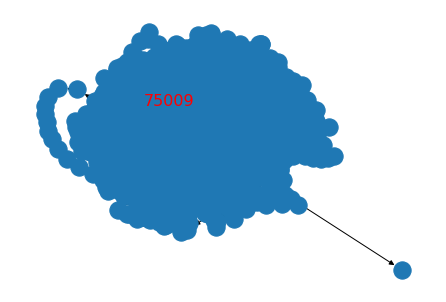

In [56]:
labels = {}    
for (p,d) in transport_graph.nodes(data=True):
    if d['type'] == 'mrt_station' and 'EW' in p:
        #set the node name as the key and the label as its value 
        labels[node] = node
#set the argument 'with labels' to False so you have unlabeled graph
pos = nx.spring_layout(transport_graph)
nx.draw(transport_graph, with_labels=False)
#Now only add labels to the nodes you require (the hubs in my case)
nx.draw_networkx_labels(transport_graph,pos,labels,font_size=16,font_color='r')